In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip /content/gdrive/MyDrive/UTK.zip

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import glob
import cv2

import os
import keras
from keras.layers import *
from keras.models import *
from keras import backend as K

path = "/content/UTKFace/"
files = os.listdir(path)
size = len(files)
print(files[3])
print("Total samples:",size)

54_0_1_20170117190137490.jpg.chip.jpg
Total samples: 23708


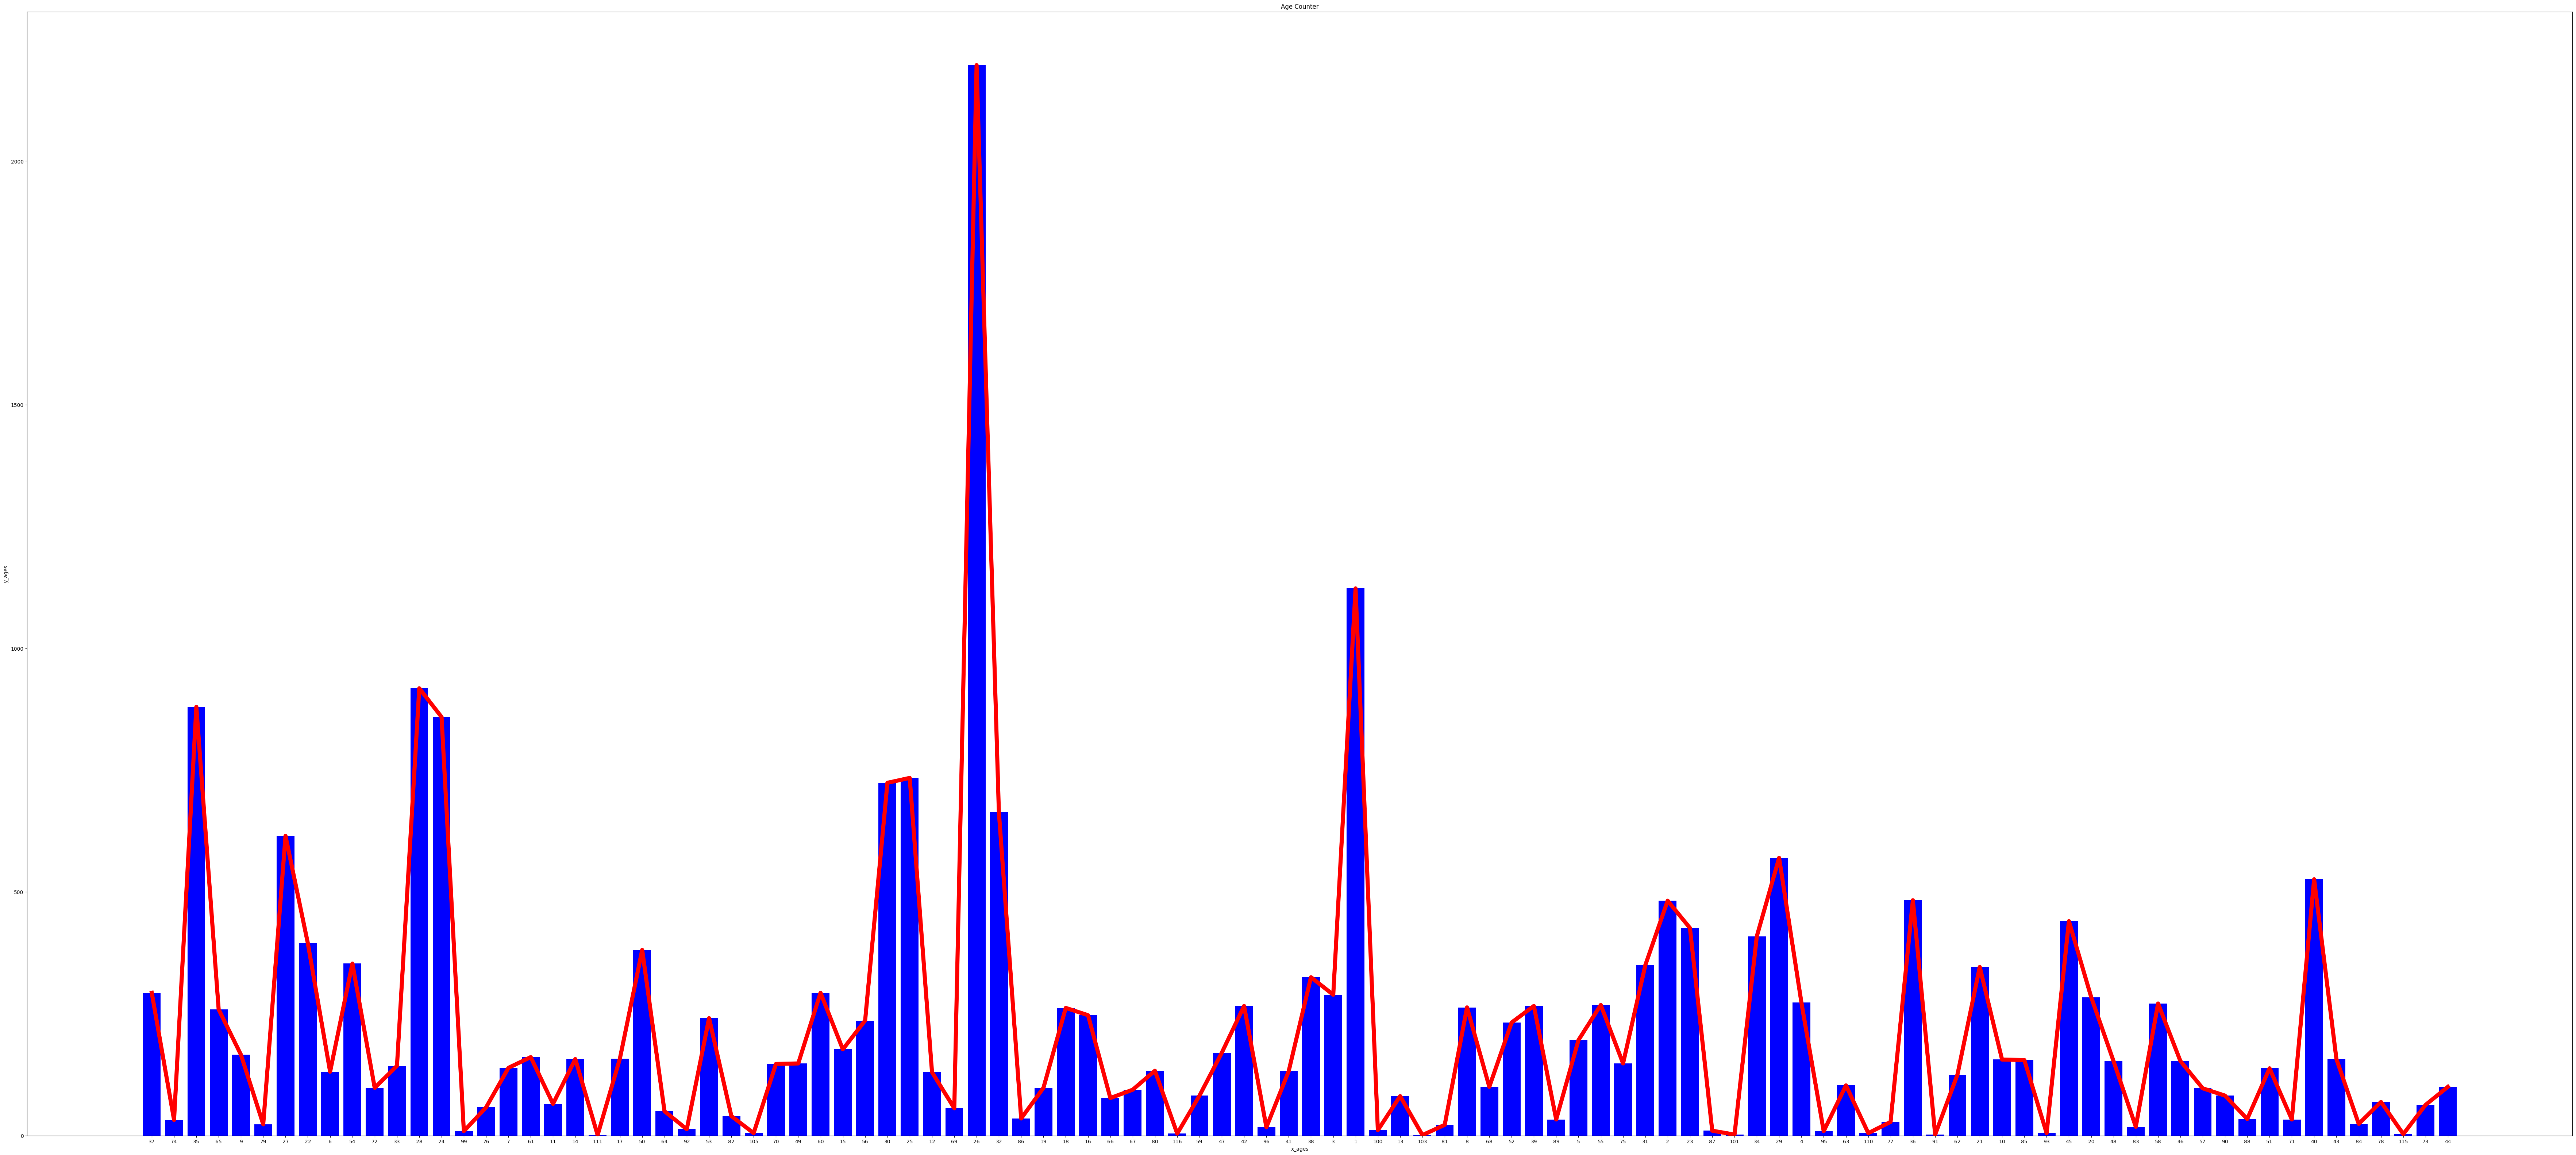

Max value: 99
Min value: 1


In [12]:
images = []
ages = []
genders = []
for file in files:
    image = cv2.imread(path+file,0)
    image = cv2.resize(image,dsize=(64,64))
    image = image.reshape((image.shape[0],image.shape[1],1))
    images.append(image)
    split_var = file.split('_')
    ages.append(split_var[0])
    genders.append(int(split_var[1]))
    
x_ages = list(set(ages))
y_ages = [ages.count(i) for i in x_ages]
plt.figure(figsize=(90, 40))
plt.plot(x_ages,y_ages, color='red', linewidth=8)
plt.bar(x_ages,y_ages, color='blue')
plt.xlabel('x_ages')
plt.ylabel('y_ages')
plt.title("Age Counter")
plt.show()
print("Max value:",max(ages))
print("Min value:",min(ages))

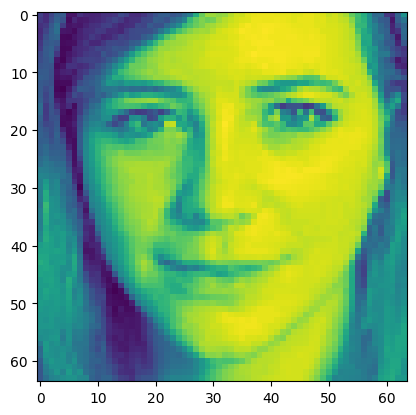

Gender Female & Age: 18


In [6]:
def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4
    
def get_gender(prob):
    if prob < 0.5:
        return "Male"
    else:
        return "Female"

def display(img):
    plt.imshow(img[:,:,0])
    plt.show()
    
idx = 10
sample = images[idx]
display(sample)
print("Gender",get_gender(genders[idx]),"& Age:",ages[idx])


In [7]:
target = np.zeros((size,2),dtype='float32')
features = np.zeros((size,sample.shape[0],sample.shape[1],1),dtype = 'float32')
for i in range(size):
    target[i,0] = age_group(int(ages[i])) / 4
    target[i,1] = int(genders[i])
    features[i] = images[i]
features = features / 255
print("Shape of the images:",sample.shape)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle = True)
print("Training images numbers:",x_train.shape[0])
print("Testing images numbers:",x_test.shape[0])

Shape of the images: (64, 64, 1)
Training images numbers: 18966
Testing images numbers: 4742


In [8]:
inputs = Input(shape=(64,64, 1))
conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
x = Dropout(0.25)(pool2)
flat = Flatten()(x)
2
dropout = Dropout(0.5)
age_model = Dense(128, activation='relu')(flat)
age_model = dropout(age_model)
age_model = Dense(64, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(32, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(1, activation='relu')(age_model)

dropout = Dropout(0.5)
gender_model = Dense(128, activation='relu')(flat)
gender_model = dropout(gender_model)
gender_model = Dense(64, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(32, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(16, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(8, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(1, activation='sigmoid')(gender_model)

model = Model(inputs=inputs, outputs=[age_model,gender_model])
model.compile(optimizer = 'adam', loss =['mse','binary_crossentropy'],metrics=['accuracy'])

model.summary()

h = model.fit(x_train,[y_train[:,0],y_train[:,1]],validation_data=(x_test,[y_test[:,0],y_test[:,1]]),
             epochs = 25, batch_size=128, shuffle = True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 62, 62, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 60, 60, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 30, 30, 64)   0           ['conv2d_1[0][0]']               
                                                                                              

dict_keys(['loss', 'dense_3_loss', 'dense_9_loss', 'dense_3_accuracy', 'dense_9_accuracy', 'val_loss', 'val_dense_3_loss', 'val_dense_9_loss', 'val_dense_3_accuracy', 'val_dense_9_accuracy'])


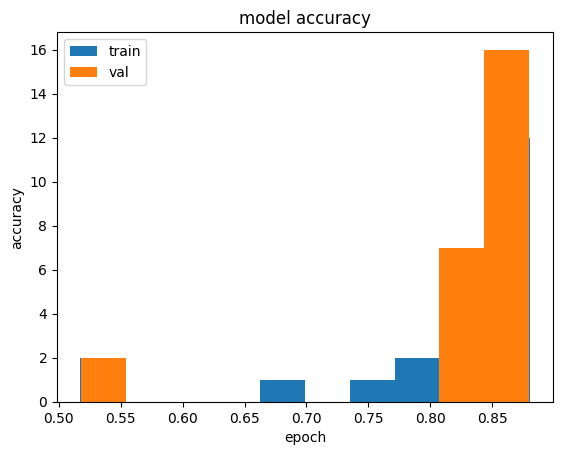

val accuracy: 82.68%


In [9]:
model.save('data.h')

history = h
print(history.history.keys())

plt.hist(history.history['dense_9_accuracy'])
plt.hist(history.history['val_dense_9_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
val_acc = np.mean(history.history['val_dense_9_accuracy']) 
print("%s: %.2f%%" % ('val accuracy',(val_acc*100)))

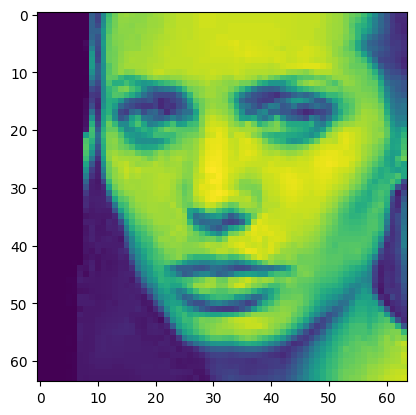

Actual Gender: Female Age: 28
1/1 [==============================] - 0s 41ms/step
Predicted Gender: Female Predicted Age: 19-30


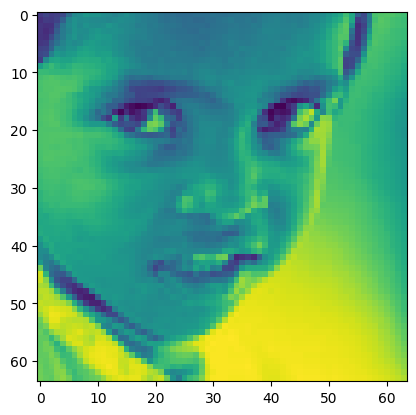

Actual Gender: Male Age: 5
1/1 [==============================] - 0s 31ms/step
Predicted Gender: Female Predicted Age: 19-30


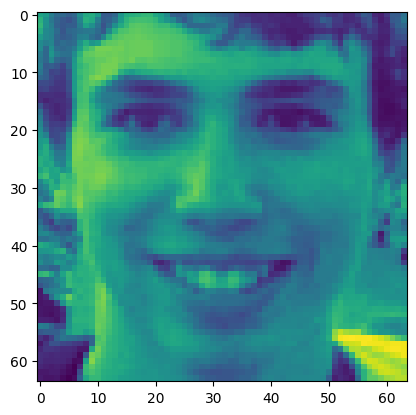

Actual Gender: Male Age: 17
1/1 [==============================] - 0s 39ms/step
Predicted Gender: Female Predicted Age: 19-30


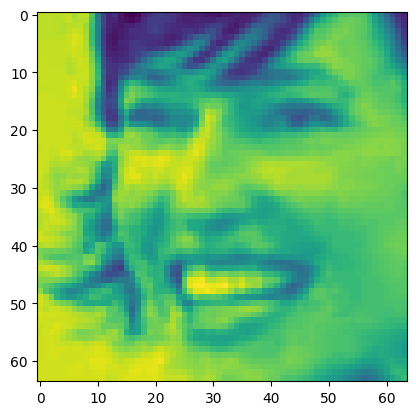

Actual Gender: Female Age: 43
1/1 [==============================] - 0s 29ms/step
Predicted Gender: Female Predicted Age: 31-80


In [13]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.show()

def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4 #unknown

def get_age(distr):
    distr = distr*4
    if distr >= 0.65 and distr <= 1.4:return "0-18"
    if distr >= 1.65 and distr <= 2.4:return "19-30"
    if distr >= 2.65 and distr <= 3.4:return "31-80"
    if distr >= 3.65 and distr <= 4.4:return "80 +"
    return "Unknown"

def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

def get_result(sample):
    sample = sample/255 
    val = model.predict( np.array([ sample ]) )
    age = get_age(val[0])
    gender = get_gender(val[1])
    print("Predicted Gender:",gender,"Predicted Age:",age)

indexes = [100,250,2345,2346]
for idx in indexes:
    sample = images[idx] 
    display(sample)
    print("Actual Gender:",get_gender(genders[idx]),"Age:",ages[idx])
    res = get_result(sample)